<a href="https://colab.research.google.com/github/Vacayy/mlp-mnist/blob/main/1_3_MNIST_CrossEntropyLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습 (김주영)

## [MY CODE] 데이터 준비
1. Trainset, Testset 로드
2. Trainset, Testset 각각에 대하여 Dataloader 생성

In [15]:
# import
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn
from torch.optim import SGD
from matplotlib import pyplot as plt

# Trainset, Testset 로드
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# DataLoader 생성
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

## [MY CODE] 모델 정의

In [16]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # Output Dimension을 Class 개수(10)로 설정

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # nn.CrossEntropyLoss 는 logits를 input으로 받기 때문에, 마지막 레이어는 activation 미적용

    return x

## [MY CODE] Model, Optimizer getter 함수

In [17]:
def get_model(input_dim, n_dim):
  model = Model(input_dim, n_dim).to('cuda')
  return model

def get_optimizer(model, lr):
  optimizer = SGD(model.parameters(), lr=lr)
  return optimizer

## [MY CODE] Accuracy 함수

In [18]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  with torch.no_grad():
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

  return acc / cnt

## [MY CODE] 모델 훈련 함수

In [19]:
def train_model(model, trainloader, testloader, optimizer, loss_function, n_epochs=100):
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):
        total_loss = 0.

        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_function(preds, labels)  # Cross entropy loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 정확도 계산
        train_accuracy = accuracy(model, trainloader)
        test_accuracy = accuracy(model, testloader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1:3d} | Loss: {total_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")

    return train_accuracies, test_accuracies

## [MY CODE] 훈련 실행

In [20]:
model = get_model(28 * 28 * 1, 1024) # Model 인스턴스 새로 생성
optimizer = get_optimizer(model, 0.001) # Learning rate 0.001 로 optimizer 생성
cross_entropy_loss = nn.CrossEntropyLoss() # 손실함수 정의 (CrossEntropyLoss)

train_accuracies, test_accuracies = train_model(model, trainloader, testloader, optimizer, cross_entropy_loss) # 학습 실행

Epoch   1 | Loss: 539.0347 | Train Accuracy: 0.1399 | Test Accuracy: 0.1382
Epoch   2 | Loss: 535.2286 | Train Accuracy: 0.2337 | Test Accuracy: 0.2376
Epoch   3 | Loss: 531.3393 | Train Accuracy: 0.3577 | Test Accuracy: 0.3664
Epoch   4 | Loss: 527.2436 | Train Accuracy: 0.4878 | Test Accuracy: 0.5017
Epoch   5 | Loss: 522.8081 | Train Accuracy: 0.5697 | Test Accuracy: 0.5773
Epoch   6 | Loss: 517.9031 | Train Accuracy: 0.6201 | Test Accuracy: 0.6299
Epoch   7 | Loss: 512.4038 | Train Accuracy: 0.6515 | Test Accuracy: 0.6594
Epoch   8 | Loss: 506.1293 | Train Accuracy: 0.6693 | Test Accuracy: 0.6775
Epoch   9 | Loss: 498.9720 | Train Accuracy: 0.6818 | Test Accuracy: 0.6876
Epoch  10 | Loss: 490.7258 | Train Accuracy: 0.6928 | Test Accuracy: 0.6972
Epoch  11 | Loss: 481.2293 | Train Accuracy: 0.7008 | Test Accuracy: 0.7054
Epoch  12 | Loss: 470.3326 | Train Accuracy: 0.7068 | Test Accuracy: 0.7124
Epoch  13 | Loss: 457.8117 | Train Accuracy: 0.7128 | Test Accuracy: 0.7167
Epoch  14 | 

## [MY CODE] 정확도 Plot 출력

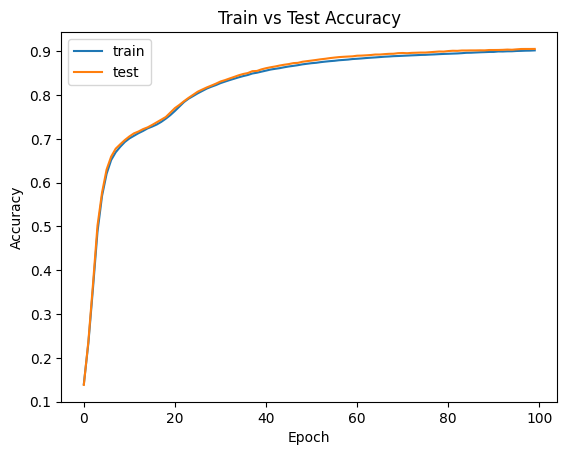

In [21]:

def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.title('Train vs Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

plot_acc(train_accuracies, test_accuracies)